In [1]:
import sys
import autograd.numpy as np
# import numpy as np
import pandas as pd
import itertools
import gmpy2 as gmp
import seaborn as sns
from importlib import reload

sys.path.append('/Users/theoares/lqcd_analysis/lqcd_analysis')
# from lqcd_analysis import visualize as plt
import visualize as plt

sys.path.append('/Users/theoares/inverse_problems/inverse_problems')
from inverse_problems import nevanlinna as nv

# import nevanlinna2 as nv

# Helper functions

In [2]:
def pole(m, z):
    return 1 / (m - z)

def analytic_dft(m, z, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(np.exp(z-m) - 1)
    pole2 = 1/(np.exp(z+m) - 1)
    return prefactor * (pole1 + pole2)

def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)
#     return prefactor * pole1

def unstable_pole(z, m, gamma):
    mpi = 0.140
    return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))

def kinematic_feature(z):
    z = z + 0*1j
    return -1*(0.25 - z)**0.5


In [3]:
def matsubara(beta, boson=False):
    n = np.arange(beta)
    if boson:
         return 2*n*np.pi/beta * 1j
    return (2*n+1)*np.pi/beta * 1j

def plot_imag_data(freq, ng, axarr):
    """
    Plots imaginary-domain data.
    """
    ax1, ax2, ax3 = axarr
    plt.errorbar(ax1, freq.real, freq.imag, fmt='.')
    plt.errorbar(ax2, freq.imag, ng.real, fmt='.')
    plt.errorbar(ax3, freq.imag, ng.imag, fmt='.')
    ax1.set_title("Matsubara frequencies")
    ax2.set_title(r"$\Re\,G_E(i\omega)$")
    ax3.set_title(r"$\Im\,G_E(i\omega)$")
    return axarr

def plot_moebius(z, ax, **kwargs):
    h = nv.moebius(z)
    plt.errorbar(ax, h.real, h.imag, fmt='.', **kwargs)    
    return ax

def plot_unit_circle(ax, **kwargs):
    x = np.linspace(-1, 1, num=100)
    plt.errorbar(ax, x, np.sqrt(1-x**2), **kwargs)
    plt.errorbar(ax, x, -np.sqrt(1-x**2), **kwargs)
    return ax

# Mock-data tests

## Define data - single particle

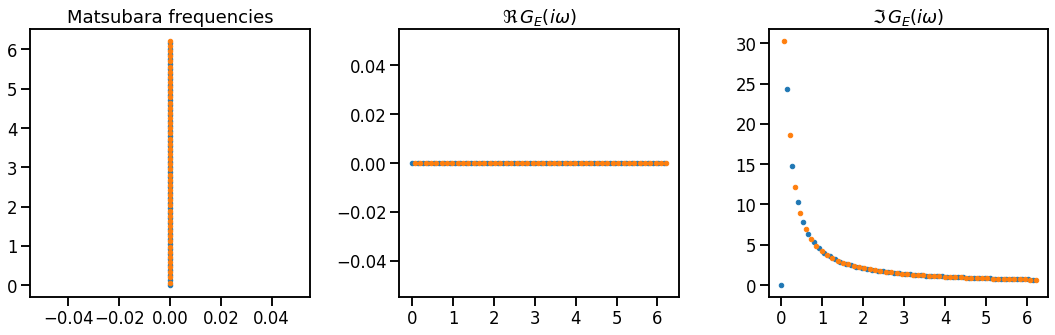

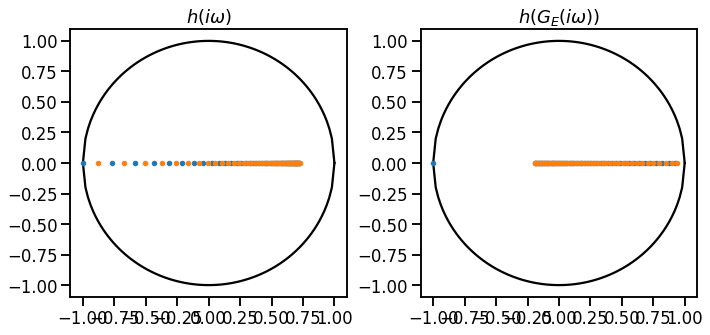

In [4]:
beta = 48
m = 0.05

freq_b = matsubara(beta, boson=True)
freq_f = matsubara(beta, boson=False)

ng_b = np.zeros(len(freq_b))
for mm in [0.05, 0.1]:
    ng_b = ng_b + analytic_ft(freq_b, mm, beta)

# ng_b = analytic_ft(freq_b, m, beta) + analytic_ft(freq_b, 2*m, beta) + analytic_ft(freq_b, 3*m, beta)
ng_f = analytic_ft(freq_f, m, beta) + analytic_ft(freq_f, 2*m, beta)

# Plot imaginary-domain data
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    plot_imag_data(freq_b, ng_b, axarr)    
    plot_imag_data(freq_f, ng_f, axarr)
    fig.tight_layout()
    
# Plot Moebius tranform of imaginary-domain data
# The result should lie within the unit disk
with sns.plotting_context("talk"):

    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr
    
    plot_unit_circle(ax1, color='k')
    plot_unit_circle(ax2, color='k')

    plot_moebius(freq_b, ax=ax1)
    plot_moebius(freq_f, ax=ax1)

    plot_moebius(ng_b, ax=ax2)
    plot_moebius(ng_f, ax=ax2)

    ax1.set_title(r"$h(i\omega)$")
    ax2.set_title(r"$h(G_E(i\omega))$")
    
    fig.tight_layout()    
    
    

## Create the interpolant and then extrapolate

/Users/theoares/inverse_problems/inverse_problems/nevanlinna.py:129: RuntimeWarning: divide by zero encountered in cdouble_scalars
  self.phi[j] = (self.imag.h[j]*d - b) / (a - self.imag.h[j]*c)
/Users/theoares/inverse_problems/inverse_problems/nevanlinna.py:129: RuntimeWarning: invalid value encountered in cdouble_scalars
  self.phi[j] = (self.imag.h[j]*d - b) / (a - self.imag.h[j]*c)
/Users/theoares/inverse_problems/inverse_problems/nevanlinna.py:107: RuntimeWarning: invalid value encountered in cdouble_scalars
  [np.conjugate(self.phi[idx]) * gamma, 1.0]],
/Users/theoares/inverse_problems/inverse_problems/nevanlinna.py:126: RuntimeWarning: invalid value encountered in matmul
  arr = arr @ self.theta_matrix(idx=k, z=y[j])
/Users/theoares/inverse_problems/inverse_problems/nevanlinna.py:159: RuntimeWarning: invalid value encountered in matmul
  arr = arr @ self.theta_matrix(idx=idx, z=z)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_ba

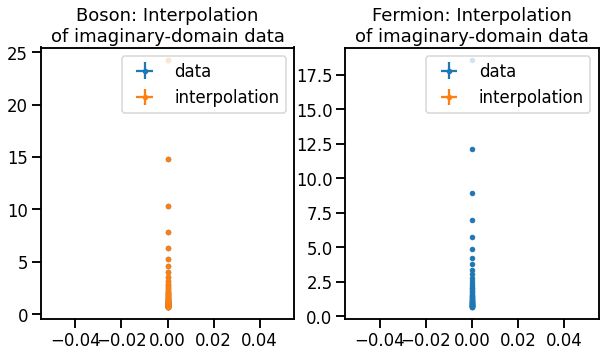

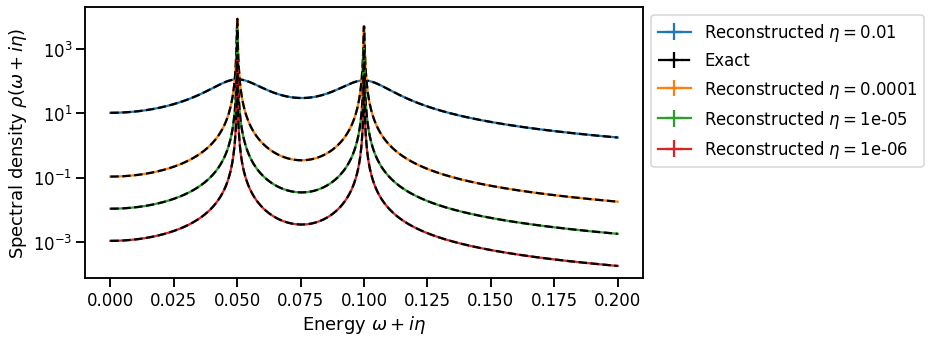

In [8]:
reload(nv)

xmin = 1
xmax = beta

# Create interpolants
interp_b = nv.Nevanlinna(freq_b[xmin:xmax], ng_b[xmin:xmax])    
interp_f = nv.Nevanlinna(freq_f[xmin:xmax], ng_f[xmin:xmax])

# Test interpolation on imaginary-domain data
test_b = np.array([interp_b.schur(z, map_back=True) for z in freq_b[xmin:xmax]])
test_f = np.array([interp_f.schur(z, map_back=True) for z in freq_f[xmin:xmax]])

with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
    ax1, ax2 = axarr
    plt.errorbar(ax1, ng_b[xmin:xmax].real, ng_b[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax1, test_b.real, test_b.imag, fmt='.', label='interpolation')

    plt.errorbar(ax2, ng_f[xmin:xmax].real, ng_f[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax2, test_f.real, test_f.imag, fmt='.', label='interpolation')

    ax1.set_title("Boson: Interpolation\nof imaginary-domain data")
    ax2.set_title("Fermion: Interpolation\nof imaginary-domain data")
    ax1.legend()
    ax2.legend()

# Solve the inverse problem via extrapolation
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10, 5))

    for eta in [1e-2, 1e-4, 1e-5, 1e-6]:
        # Extrapolate the interpolation toward the real axis
        omega, rho = interp_b(start=0, stop=0.2, num=1000, eta=eta)
        sign = +1 if eta > 0 else -1
        plt.errorbar(ax, omega.real, rho.imag*sign, label=r"Reconstructed $\eta=$"+str(eta))

        label = 'Exact' if eta == 1e-2 else None
        y = 0
        for m in [0.05, 0.1]:
            y = y + analytic_ft(omega, m, beta)
        y = y.imag
        plt.errorbar(ax, x=omega.real, y=y*sign, fmt='--', color='k', label=label)
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"Energy $\omega + i \eta$")
    ax.set_ylabel(r"Spectral density $\rho(\omega + i \eta)$")
    
    

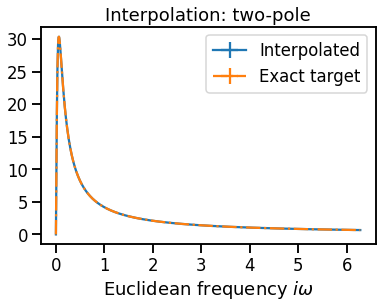

In [9]:
with sns.plotting_context("talk"):
    z = np.linspace(0, 2*np.pi, num=1000)*1j + 1e-4
    y = np.array([interp_b.schur(zi, map_back=True) for zi in z])
    fig, ax = plt.subplots(1)

    plt.errorbar(ax, z.imag, y.imag, fmt='-', label='Interpolated')

    y = analytic_ft(z, 0.05, beta) + analytic_ft(z, 0.1, beta)
    plt.errorbar(ax, z.imag, y.imag, fmt='-.', label='Exact target')
    
    ax.set_xlabel(r"Euclidean frequency $i\omega$")
    ax.set_title(r"Interpolation: two-pole")
    ax.legend()
#     ax.set_ylim(bottom=0,top=40)
    

## Playing with derivatives, hardy functions

<AxesSubplot:>

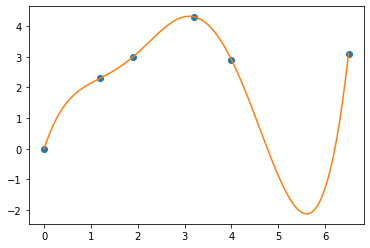

In [10]:
import scipy.interpolate as interpolate

from scipy.interpolate import BSpline

x = np.array([ 0. ,  1.2,  1.9,  3.2,  4. ,  6.5])
y = np.array([ 0. ,  2.3,  3. ,  4.3,  2.9,  3.1])

t, c, k = interpolate.splrep(x, y, s=0, k=4)
bspline = interpolate.BSpline(t, c, k, extrapolate=False)

fig, ax = plt.subplots(1)
plt.errorbar(ax, x, y, fmt='o')
xx = np.linspace(0, 6.5, num=100)
yy = bspline(xx)
plt.errorbar(ax, xx, yy)


<AxesSubplot:>

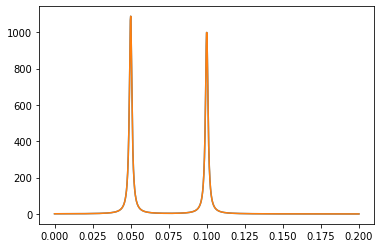

In [11]:

def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline


fig, ax = plt.subplots(1)

# Evaluate the function
eta = 1e-3
omega, rho = interp_b(start=0, stop=0.2, num=1000, eta=eta)
sign = +1 if eta > 0 else -1
plt.errorbar(ax, omega.real, rho.imag*sign, label=r"Reconstruction")

# Construct B-spline interpolation of the function
bspline = build_bspline(omega.real, rho.imag*sign)
plt.errorbar(ax, omega.real, bspline(omega.real))

# Compute derivatives using the spline
# ylim = ax.get_ylim()
# bspline_d2 = bspline.derivative(nu=2)
# plt.errorbar(ax, omega.real, bspline_d2(omega.real))
# ax.set_ylim(*ylim)


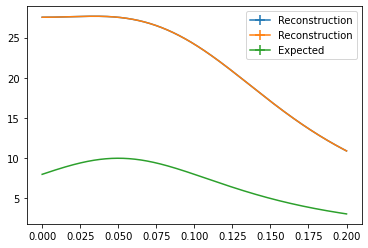

In [12]:
def hardy(k, z):
    return ((z - 1j)/(z + 1j))**k / (np.sqrt(np.pi)*(z + 1j))

def expansion(z, p=None):
    if p is None:
        raise ValueError("Please specify p")
    a = p['a']
    b = p['b']
    result = 0*1j
    for k, (ak, bk) in enumerate(zip(a,b)):
        result += ak*hardy(k, z) + bk*np.conjugate(hardy(k, z))
    return result
    
p = {'a': [1e4], 'b': [0]}

eta = 1e-1
omega = nv.RealDomainData(start=0, stop=0.2, num=1000, eta=eta).freq
rho1 = np.array([interp_b.schur(z, map_back=True) for z in omega])
rho2 = np.array([interp_b.schur(z, map_back=True, fcn=expansion, p=p) for z in omega])

sign = +1 if eta > 0 else -1
fig, ax = plt.subplots(1)
# plt.errorbar(ax, omega.real, (rho1.imag-rho2.imag)*sign, label=r"Reconstruction")
plt.errorbar(ax, omega.real, rho1.imag*sign, label=r"Reconstruction")
plt.errorbar(ax, omega.real, rho2.imag*sign, label=r"Reconstruction")

xx = omega.real
yy = eta/(xx**2 + eta**2 - 2*0.05*xx + 0.05**2)
plt.errorbar(ax, xx, yy, label="Expected")
ax.legend()

Ok, so I can evaluate the interpolant including the final step with the Hardy functions.
Next I need to be able to evaulate the functional which we will optimize.
$$
|1 - \int d\omega \rho(\omega)|^2 + \lambda \int dw \rho''(\omega)^2
$$

In [13]:
def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline

def evaluate_functional(interpolator, p, start=0, stop=0.2, eta=1e-3):

    lam = 1e-5
    sign = +1 if eta > 0 else -1
    omega = nv.RealDomainData(start=start, stop=stop, num=1000, eta=eta).freq
    rho = np.array([interpolator.schur(z, map_back=True, fcn=expansion, p=p) for z in omega])
    
    # Construct B-spline interpolation of the function and its derivatives
    bspline = build_bspline(omega.real, rho.imag*sign)
    bspline_d2 = bspline.derivative(nu=2)

    
    x = np.linspace(start, stop, 1000)
    normalization = (1 - np.trapz(y=bspline(omega.real), x=omega.real))**2
    smoothness = lam * np.trapz(y=bspline_d2(omega.real)**2, x=omega.real)
    return smoothness, normalization
    
p = {'a': [0], 'b': [0]}
evaluate_functional(interp_b, p)
    
    

(52048452840.77178, 31.013335055500747)

# Old code below -- beware!

## Testing autograd

In [11]:
from autograd import grad
from autograd import holomorphic_grad
import autograd

def afcn(x):
    eta = 0.1
    return np.imag(interp_b.schur(x + eta*1j))

grad_schur = holomorphic_grad(interp_b.schur) 
grad_test = autograd.grad(afcn)

d2_schur = holomorphic_grad(holomorphic_grad(interp_b.schur))

xx = np.linspace(0, 0.2, num=100)
yy = np.array([grad_schur(xi + 0.1*1j) for xi in xx])
# yalt = np.array([grad_test(xi) for xi in xx])
y2 = np.array([d2_schur(xi + 0.1*1j) for xi in xx])

# fig, ax = plt.subplots(1)
# plt.errorbar(ax, xx, yy.real, label='real')
# plt.errorbar(ax, xx, yy.imag, label='imag')

# plt.errorbar(ax, xx, yalt, label='alt')
# plt.errorbar(ax, xx, y2, label='d2')


# ax.legend()
# ax.set_yscale("log")



TypeError: must be real number, not ArrayBox

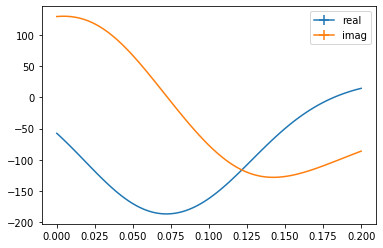

In [57]:
fig, ax = plt.subplots(1)
plt.errorbar(ax, xx, yy.real, label='real')
plt.errorbar(ax, xx, yy.imag, label='imag')

# plt.errorbar(ax, xx, yalt, label='alt')
# plt.errorbar(ax, xx, y2.imag, label='d2')

ax.legend()
# ax.set_ylim(-200, 200)




Ok, so a couple of calls to holomorphic_grad does give me the required 2nd derivatives.
The results look smooth, and the figures seem to agree with what I'm finding in Mathematica.

In [24]:
def hardy(k, z):
    return ((z - 1j)/(z + 1j))**k / (np.sqrt(np.pi)*(z + 1j))

def expansion(z, p=None):
    if p is None:
        raise ValueError("Please specify p")
    a = p['a']
    b = p['b']
    result = 0*1j
    for k, (ak, bk) in enumerate(zip(a,b)):
        result += ak*hardy(k, z) + bk*np.conjugate(hardy(k, z))
    return result
    
# Should modify Schur.__call__ to accepts a function for "theta_{M+1}"
# Then the functional itself will be something like:

omega_min = -2
omega_max = +2
eta = 1e-3

omegas = np.linspace(omega_min, omega_max, num=500) + eta*1j
p = {'a': [0, 0, 0], 'b': [0, 0, 0]}

y = interp_b.schur(0, expansion, p=p)
integral_1 = np.trapz(x=omegas.real, y=y.imag)

d2_schur = holomorphic_grad(holomorphic_grad(interp_b.schur))

    

{'p': {'a': [0, 0, 0], 'b': [0, 0, 0]}}


IndexError: list assignment index out of range

# Unstable particle

## Kinematic features

Text(0.5, 1.0, 'Imag component')

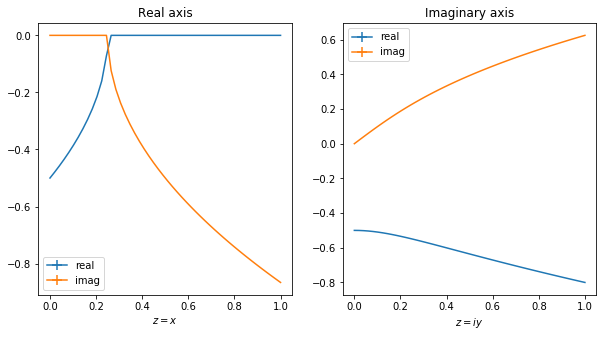

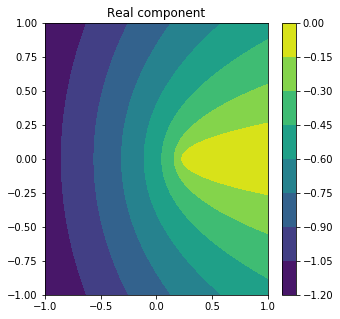

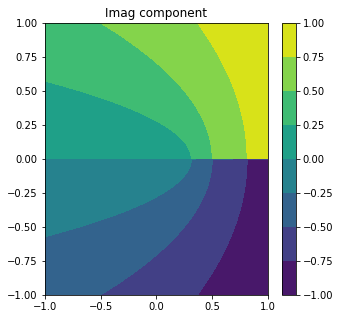

In [51]:
from matplotlib.colors import LogNorm
# Plot an unstable particle = single pool in quadrant IV at z = (M - i*Gamma)

fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
ax1, ax2 = axarr

z = np.linspace(0, 1) + 0*1j
f = kinematic_feature(z)
plt.errorbar(ax1, z.real, f.real, label='real')
plt.errorbar(ax1, z.real, f.imag, label='imag')
ax1.set_title("Real axis")
ax1.set_xlabel("$z=x$")
ax1.legend()

z = np.linspace(0, 1)*1j
f = kinematic_feature(z)

plt.errorbar(ax2, z.imag, f.real, label='real')
plt.errorbar(ax2, z.imag, f.imag, label='imag')
ax2.set_title("Imaginary axis")
ax2.set_xlabel("$z=iy$")
ax2.legend()

# Heatmaps of real and imaginary components in complex plane
x, y = np.meshgrid(np.linspace(-1, 1, num=1000), np.linspace(-1, 1, num=1000))
def f(x, y):
    z = x + 1j*y
    return kinematic_feature(z)

z = f(x, y)
zreal = z.real
zimag = z.imag

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
cs = ax.contourf(x, y, z.real)# norm=LogNorm())

cbar = fig.colorbar(cs)
ax.set_title("Real component")

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
cs = ax.contourf(x, y, z.imag)#, norm=LogNorm())
cbar = fig.colorbar(cs)
ax.set_title("Imag component")

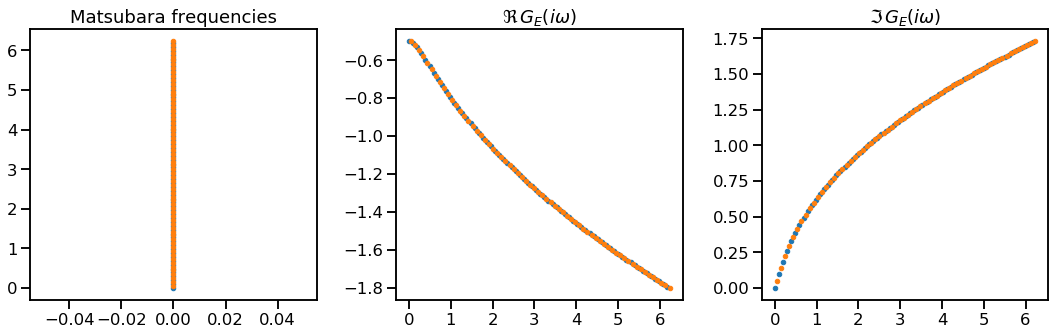

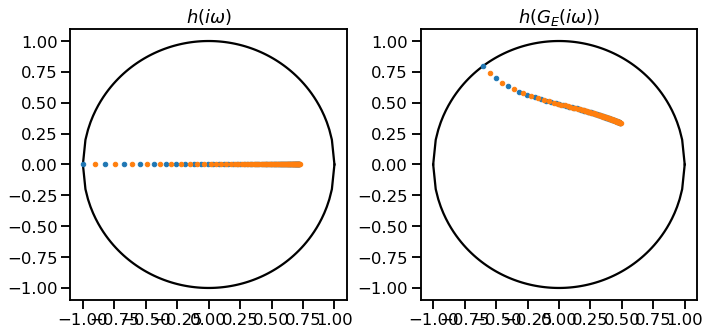

In [53]:
beta = 64
m = 0.5
gamma = 0.25

freq_b = matsubara(beta, boson=True)
freq_f = matsubara(beta, boson=False)

ng_b = kinematic_feature(freq_b)
ng_f = kinematic_feature(freq_f)

# Plot imaginary-domain data
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    plot_imag_data(freq_b, ng_b, axarr)    
    plot_imag_data(freq_f, ng_f, axarr)
    fig.tight_layout()
    
# Plot Moebius tranform of imaginary-domain data
# The result should lie within the unit disk
with sns.plotting_context("talk"):

    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr
    
    plot_unit_circle(ax1, color='k')
    plot_unit_circle(ax2, color='k')

    plot_moebius(freq_b, ax=ax1)
    plot_moebius(freq_f, ax=ax1)

    plot_moebius(ng_b, ax=ax2)
    plot_moebius(ng_f, ax=ax2)

    ax1.set_title(r"$h(i\omega)$")
    ax2.set_title(r"$h(G_E(i\omega))$")
    
    fig.tight_layout()    
    
    

Initializing
Initializing


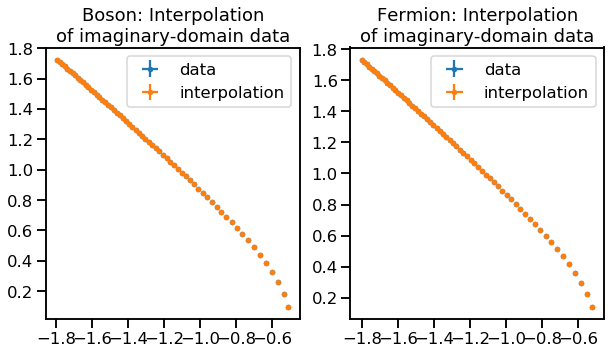

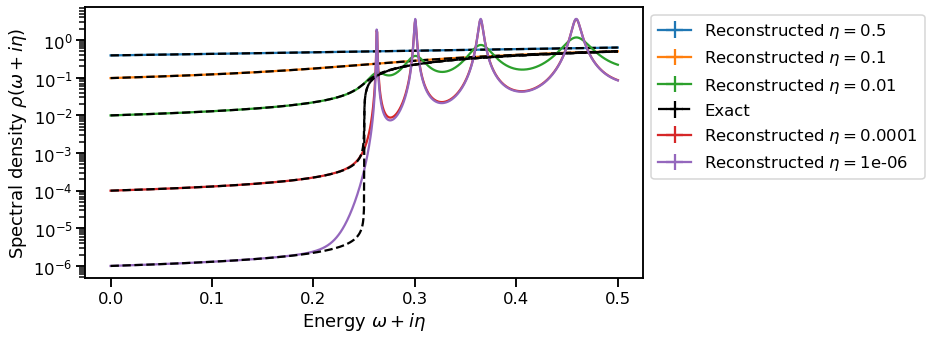

In [57]:
xmin = 1
xmax = beta

# Create interpolants
interp_b = nv.Nevanlinna(freq_b[xmin:xmax], ng_b[xmin:xmax])    
interp_f = nv.Nevanlinna(freq_f[xmin:xmax], ng_f[xmin:xmax])

# Test interpolation on imaginary-domain data
test_b = np.array([interp_b.schur(z, map_back=True) for z in freq_b[xmin:xmax]])
test_f = np.array([interp_f.schur(z, map_back=True) for z in freq_f[xmin:xmax]])

with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
    ax1, ax2 = axarr
    plt.errorbar(ax1, ng_b[xmin:xmax].real, ng_b[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax1, test_b.real, test_b.imag, fmt='.', label='interpolation')

    plt.errorbar(ax2, ng_f[xmin:xmax].real, ng_f[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax2, test_f.real, test_f.imag, fmt='.', label='interpolation')

    ax1.set_title("Boson: Interpolation\nof imaginary-domain data")
    ax2.set_title("Fermion: Interpolation\nof imaginary-domain data")
    ax1.legend()
    ax2.legend()

# Solve the inverse problem via extrapolation
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10, 5))
#     ax.axvline(x=m, color='k')
    for eta in [0.5, 1e-1, 1e-2, 1e-4, 1e-6]:
        # Extrapolate the interpolation toward the real axis
        omega, rho = interp_f(start=0, stop=0.5, num=1000, eta=eta)
        sign = +1 if eta > 0 else -1
        plt.errorbar(ax, omega.real, rho.imag*sign, label=r"Reconstructed $\eta=$"+str(eta))

        label = 'Exact' if eta == 1e-2 else None
        y = kinematic_feature(omega)
        plt.errorbar(ax, x=omega.real, y=y.imag, fmt='--', color='k', label=label)
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"Energy $\omega + i \eta$")
    ax.set_ylabel(r"Spectral density $\rho(\omega + i \eta)$")
    
    

## Poles on the second sheet

<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: divide by zero encountered in true_divide
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: invalid value encountered in sqrt
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: divide by zero encountered in true_divide
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: invalid value encountered in true_divide
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: invalid value encountered in multiply
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-111-1efba27503b5>:35: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(x, y, z.real, norm=LogNorm())
<ipython-input-111-1efba27503b5>:41: UserWarning: Log scale: values of z <= 0 have been masked

Text(0.5, 1.0, 'Imag component')

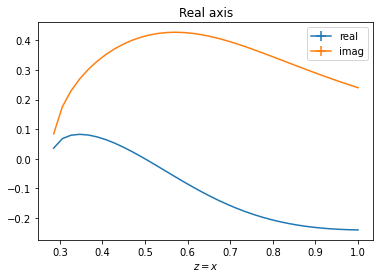

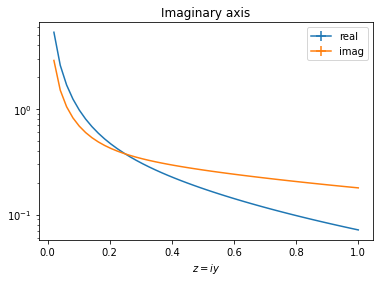

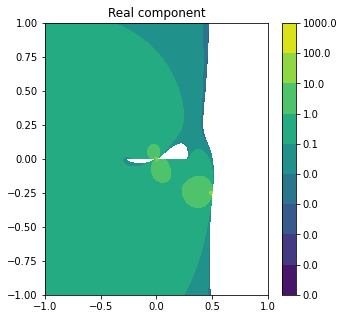

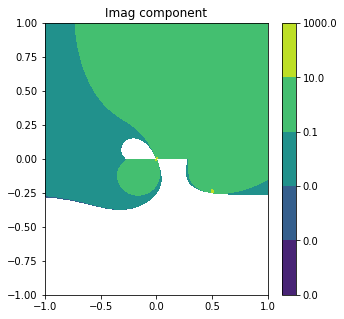

In [111]:
from matplotlib.colors import LogNorm
# Plot an unstable particle = single pool in quadrant IV at z = (M - i*Gamma)


z = np.linspace(0, 1)
f = -unstable_pole(z, m=0.5, gamma=0.5)
fig, ax = plt.subplots(1)
plt.errorbar(ax, z, f.real, label='real')
plt.errorbar(ax, z, f.imag, label='imag')
ax.set_title("Real axis")
ax.set_xlabel("$z=x$")
ax.legend()

z = np.linspace(0, 1)*1j
f = -unstable_pole(z, m=0.5, gamma=0.25)
fig, ax = plt.subplots(1)
plt.errorbar(ax, z.imag, f.real, label='real')
plt.errorbar(ax, z.imag, f.imag, label='imag')
ax.set_title("Imaginary axis")
ax.set_xlabel("$z=iy$")
ax.legend()
ax.set_yscale("log")

# Heatmaps of real and imaginary components in complex plane
x, y = np.meshgrid(np.linspace(-1, 1, num=1000), np.linspace(-1, 1, num=1000))
def f(x, y, m=0.5, gamma=0.25):
    z = x + 1j*y
    return -unstable_pole(z, m, gamma)

z = f(x, y)
zreal = z.real
zimag = z.imag

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
cs = ax.contourf(x, y, z.real, norm=LogNorm())

cbar = fig.colorbar(cs)
ax.set_title("Real component")

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
cs = ax.contourf(x, y, z.imag, norm=LogNorm())
cbar = fig.colorbar(cs)
ax.set_title("Imag component")

<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: divide by zero encountered in true_divide
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: invalid value encountered in true_divide
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))
<ipython-input-109-b66c4bf8d6f9>:18: RuntimeWarning: invalid value encountered in multiply
  return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))


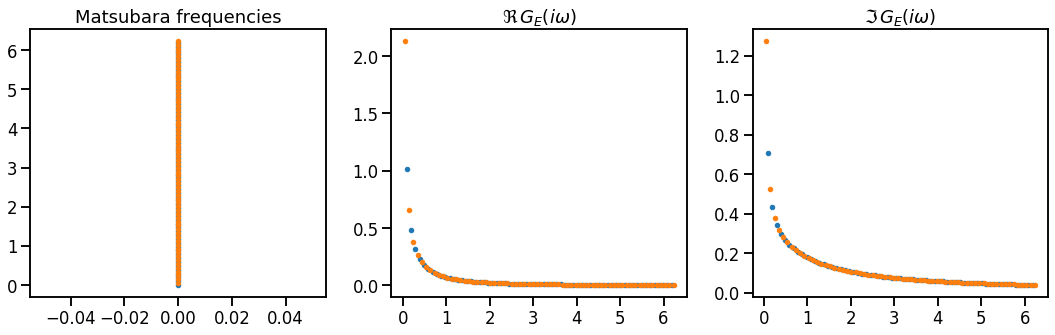

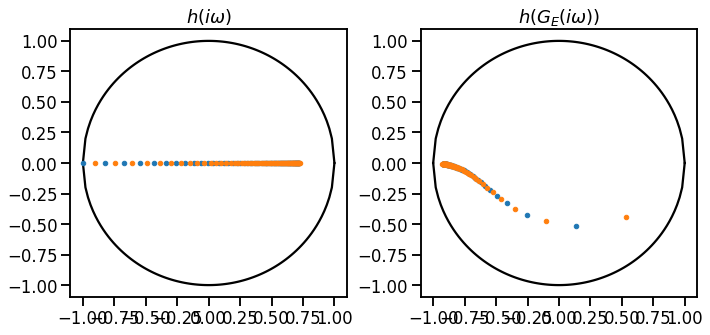

In [112]:
beta = 64
m = 0.5
gamma = 0.25

freq_b = matsubara(beta, boson=True)
freq_f = matsubara(beta, boson=False)

ng_b = -unstable_pole(freq_b, m, gamma)
ng_f = -unstable_pole(freq_f, m, gamma)

# Plot imaginary-domain data
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    plot_imag_data(freq_b, ng_b, axarr)    
    plot_imag_data(freq_f, ng_f, axarr)
    fig.tight_layout()
    
# Plot Moebius tranform of imaginary-domain data
# The result should lie within the unit disk
with sns.plotting_context("talk"):

    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr
    
    plot_unit_circle(ax1, color='k')
    plot_unit_circle(ax2, color='k')

    plot_moebius(freq_b, ax=ax1)
    plot_moebius(freq_f, ax=ax1)

    plot_moebius(ng_b, ax=ax2)
    plot_moebius(ng_f, ax=ax2)

    ax1.set_title(r"$h(i\omega)$")
    ax2.set_title(r"$h(G_E(i\omega))$")
    
    fig.tight_layout()    
    
    

Initializing
Initializing


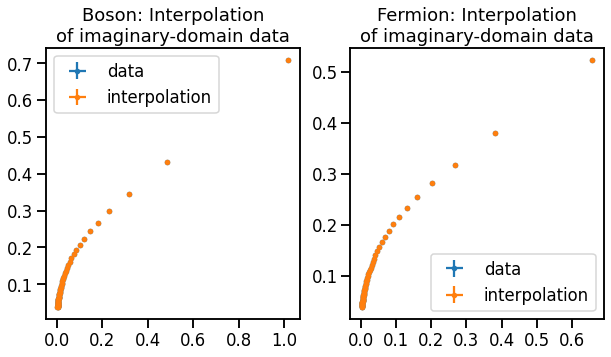

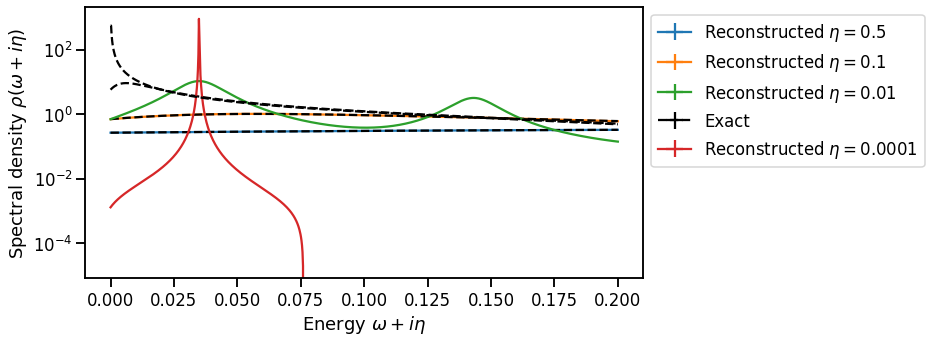

In [113]:
xmin = 1
xmax = beta

# Create interpolants
interp_b = nv.Nevanlinna(freq_b[xmin:xmax], ng_b[xmin:xmax])    
interp_f = nv.Nevanlinna(freq_f[xmin:xmax], ng_f[xmin:xmax])

# Test interpolation on imaginary-domain data
test_b = np.array([interp_b.schur(z, map_back=True) for z in freq_b[xmin:xmax]])
test_f = np.array([interp_f.schur(z, map_back=True) for z in freq_f[xmin:xmax]])

with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
    ax1, ax2 = axarr
    plt.errorbar(ax1, ng_b[xmin:xmax].real, ng_b[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax1, test_b.real, test_b.imag, fmt='.', label='interpolation')

    plt.errorbar(ax2, ng_f[xmin:xmax].real, ng_f[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax2, test_f.real, test_f.imag, fmt='.', label='interpolation')

    ax1.set_title("Boson: Interpolation\nof imaginary-domain data")
    ax2.set_title("Fermion: Interpolation\nof imaginary-domain data")
    ax1.legend()
    ax2.legend()

# Solve the inverse problem via extrapolation
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10, 5))
#     ax.axvline(x=m, color='k')
    for eta in [0.5, 1e-1, 1e-2, 1e-4]:
        # Extrapolate the interpolation toward the real axis
        omega, rho = interp_f(start=0, stop=0.2, num=1000, eta=eta)
        sign = +1 if eta > 0 else -1
        plt.errorbar(ax, omega.real, rho.imag*sign, label=r"Reconstructed $\eta=$"+str(eta))

        label = 'Exact' if eta == 1e-2 else None
        y = -unstable_pole(omega, m, gamma)
        plt.errorbar(ax, x=omega.real, y=y.imag, fmt='--', color='k', label=label)
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"Energy $\omega + i \eta$")
    ax.set_ylabel(r"Spectral density $\rho(\omega + i \eta)$")
    
    

# Model for R(s)

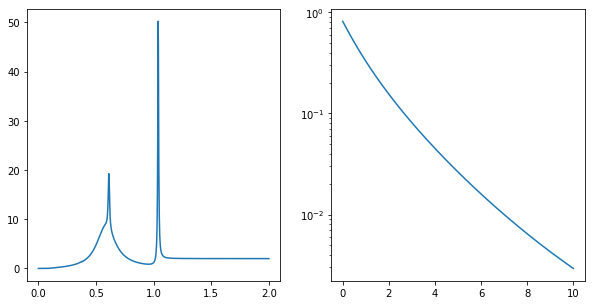

In [22]:
def r_ratio(s):
    """
    Units:
    c: dimensionless
    m, gamma: GeV
    """
    c = [655.5, 8.5, 11.5, 50.0] 
    m = [0.7819, 0.7650, 0.7820, 1.0195]
    gamma = [0.0358, 0.130, 0.00829, 0.00426]
    root_s = np.sqrt(s)

    def f(n, root_s):
        return c[n]*gamma[n]**2 / (4*(root_s - m[n])**2 + gamma[n]**2)
    
    mpi = 0.140  # GeV
    result = np.zeros(len(s))
    region1 = (2*mpi < root_s) & (root_s < 4.4*mpi)
    region2 = (4.4*mpi < root_s) & (root_s < m[3])
    region3 = (m[3] < root_s)

    result[region1] += 0.25*(1 - 4*mpi**2/s[region1])**1.5*(0.6473 + f(0, root_s[region1]))
    result[region2] += f(1, root_s[region2]) + f(2, root_s[region2])
    result += f(3, root_s)
    result[region3] += 3*((2/3)**2 + (1/3)**2 + (1/3)**2)
    return result

omega = np.linspace(0, 2, num=1000)
rrat = r_ratio(omega)
t = np.linspace(0, 10, num=len(omega))
rrat_E = [np.trapz(x=omega, y=rrat/(2*np.pi)*np.exp(-omega*ti)) for ti in t]
rrat_E = np.array(rrat_E)
# Move to Euclidean space via the Laplace transform
# G_E(t) = \int d\omega/(2pi) rho(omega) exp(-omega*t)


fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
ax1, ax2 = axarr
plt.errorbar(ax1, omega, rrat)
plt.errorbar(ax2, t, rrat_E)
ax2.set_yscale("log")



/Users/willjay/GitHub/lqcd_analysis/lqcd_analysis/visualize.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=x, xerr=xerr, y=y, yerr=yerr, **kwargs)
/Users/willjay/GitHub/lqcd_analysis/lqcd_analysis/visualize.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=x, xerr=xerr, y=y, yerr=yerr, **kwargs)
/Users/willjay/GitHub/lqcd_analysis/lqcd_analysis/visualize.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=x, xerr=xerr, y=y, yerr=yerr, **kwargs)


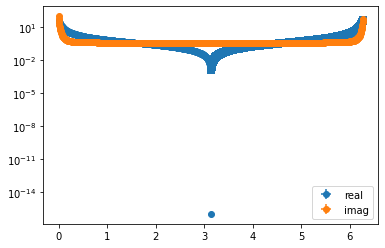

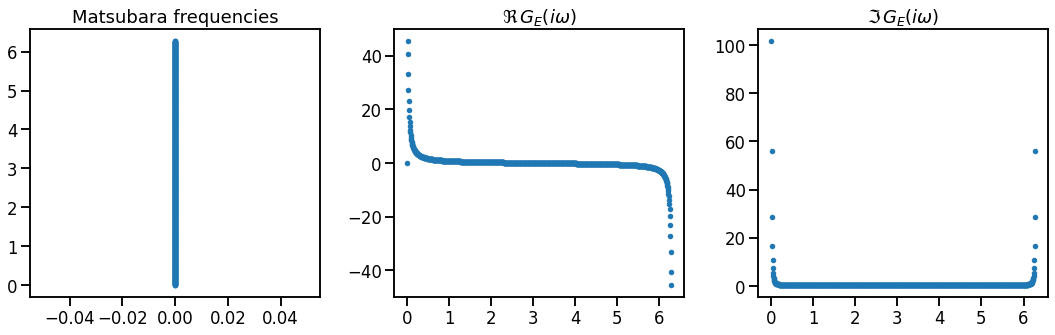

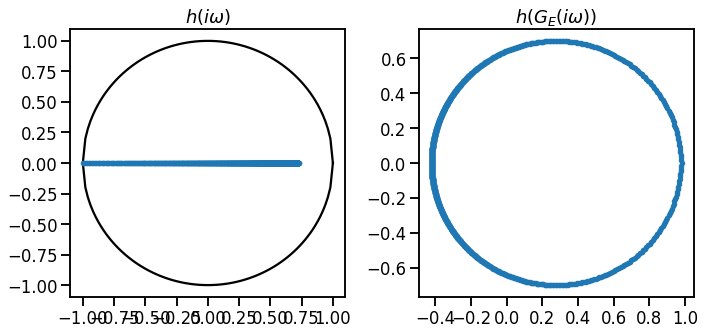

In [23]:
npts = len(rrat_E)
ng_r = np.fft.fft(rrat_E)*1j
fig, ax = plt.subplots(1)

freq_r = 2*np.pi*np.arange(len(ng_r))/len(ng_r) * 1j

plt.mirror(ax=ax, x=freq_r.imag, y=ng_r.real, label='real')
plt.mirror(ax=ax, x=freq_r.imag, y=ng_r.imag, label='imag')
ax.legend()
ax.set_yscale("log")

# Plot imaginary-domain data
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    plot_imag_data(freq_r, ng_r, axarr)    
    fig.tight_layout()
    
# Plot Moebius tranform of imaginary-domain data
# The result should lie within the unit disk
with sns.plotting_context("talk"):

    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
    ax1, ax2 = axarr
    plot_unit_circle(ax1, color='k')
    plot_moebius(freq_r, ax=ax1)
    plot_moebius(ng_r, ax=ax2)

    ax1.set_title(r"$h(i\omega)$")
    ax2.set_title(r"$h(G_E(i\omega))$")
    
    fig.tight_layout()    
    
    

Initializing


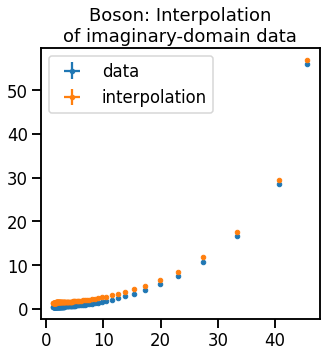

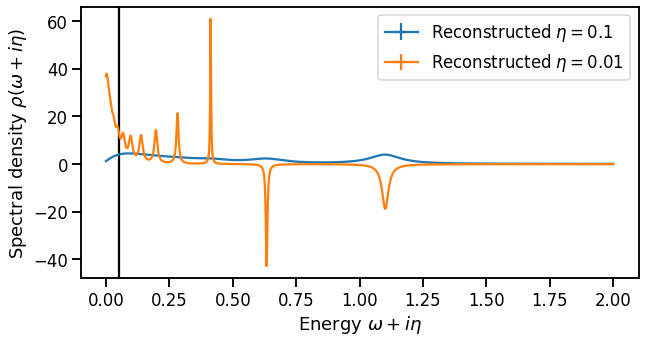

In [24]:
xmin = 1
xmax = 100

# Create interpolants
interp_r = nv.Nevanlinna(freq_r[xmin:xmax], ng_r[xmin:xmax])    


# Test interpolation on imaginary-domain data
test_r = np.array([interp_r.schur(z, map_back=True) for z in freq_r[xmin:xmax]])

with sns.plotting_context("talk"):
    fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))
    plt.errorbar(ax1, ng_r[xmin:xmax].real, ng_r[xmin:xmax].imag, fmt='.', label='data')
    plt.errorbar(ax1, test_r.real, test_r.imag+1, fmt='.', label='interpolation')
    ax1.set_title("Boson: Interpolation\nof imaginary-domain data")
    ax1.legend()

# Solve the inverse problem via extrapolation
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.axvline(x=m, color='k')
    for eta in [1e-1, 1e-2]:#, 1e-4]: #1e-12]:
        # Extrapolate the interpolation toward the real axis
        omega, rho = interp_r(start=0, stop=2.0, num=1000, eta=eta)
        plt.errorbar(ax, omega.real, rho.imag, label=r"Reconstructed $\eta=$"+str(eta))

#         label = 'Exact' if eta == 1e-2 else None
#         y = (analytic_ft(omega, m, beta) + analytic_ft(omega, 2*m, beta)).imag
#         plt.errorbar(ax, x=omega.real, y=y, fmt='--', color='k', label=label)
#     ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"Energy $\omega + i \eta$")
    ax.set_ylabel(r"Spectral density $\rho(\omega + i \eta)$")
    
    

<AxesSubplot:>

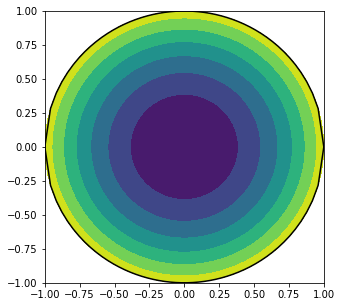

In [26]:

# Data to plot.
x, y = np.meshgrid(np.linspace(-1, 1, num=1000), np.linspace(-1, 1, num=1000))
z = x**2 + y**2

mask = (x**2 + y**2 > 1)
z = np.ma.array(z, mask=mask)
# z = np.sin(0.5 * x) * np.cos(0.52 * y)

fig, ax = plt.subplots(ncols=1, figsize=(5,5))
cs = ax.contourf(x, y, z)

x = np.linspace(-1, 1)
plt.errorbar(ax, x, np.sqrt(1-x**2), color='k')
plt.errorbar(ax, x, -np.sqrt(1-x**2), color='k')

# Old code below

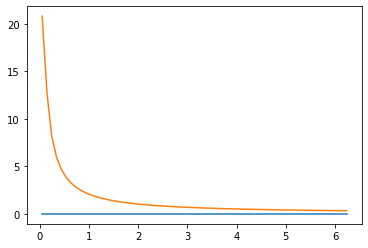

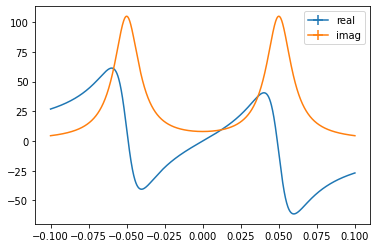

In [142]:
m0 = 0.05
beta = 64
n = np.arange(beta)
z = (2*n+1)*np.pi/beta*1j
f = analytic_ft(m0, z, beta)

fig, ax = plt.subplots(1)
plt.errorbar(ax, z.imag, f.real)
plt.errorbar(ax, z.imag, f.imag)


fig, ax = plt.subplots(1)
z = np.linspace(-0.1, 0.1, num=1000) + 0.01*1j
f = analytic_ft(m0, z, beta)
plt.errorbar(ax, z.real, f.real, label='real')
plt.errorbar(ax, z.real, f.imag, label='imag')
ax.legend()





# Nevanlinna Interpolation

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


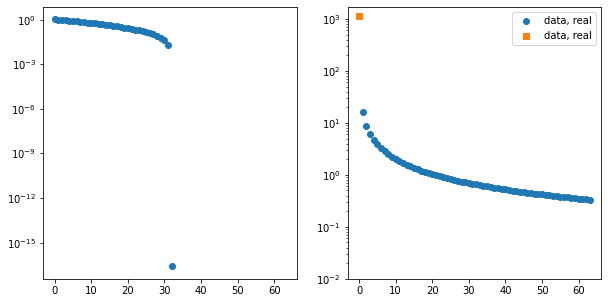

In [144]:
# Euclidean Green function C(tau), with tau = i*t
# Single state with unit amplitude
nt = 64
tau = np.arange(0, nt, dtype=float)
m0 = 0.05
masses = [m0,]
amps = [1,]
corr = np.zeros(len(tau), dtype=float)
for mass, amp in zip(masses, amps):
    corr += amp * (np.exp(-mass*tau) + np.exp(-mass*(nt-tau)))
#     corr += amp * (np.exp(-mass*tau))

# Rephase for fermionic boundardy conditions
# discrete Fourier transform
phase = np.exp(1j*np.pi*tau/nt)
corr = phase*corr

# Matsubara Green function C(i*omega)
# The Matsubara Green function is the Fourier transform
# of the Euclidean Green function

freq = np.arange(len(tau))
# ng = np.fft.fft(corr)
ng = -analytic_ft(m0, (2*freq+1)*np.pi/nt, nt)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.errorbar(tau, corr, fmt='o')
ax1.set_yscale("log")

for label, yy in {'data, real': ng.real, 'data, imag': ng.imag}.items():
    pos = yy > 0
    neg = yy < 0
    if np.any(pos):
        ax2.errorbar(freq[pos], yy[pos], fmt='o', label=label)
    if np.any(neg):
        ax2.errorbar(freq[neg], -yy[neg], fmt='s', label=label)

# ax2.errorbar(freq, ng.real, fmt='o', label='real')
# ax2.errorbar(freq, ng.imag, fmt='o', label='imag')

# y = np.sinh(m0) / (np.cosh(m0) - np.cos(2*np.pi*freq/nt)) * (1 - np.exp(-nt*m0))
# ax2.errorbar(freq, y, label='analytic calculation - bosonic')

# z = 2*np.pi*freq/nt*1j
# y = analytic_dft(m0, z, nt)
# for label, yy in {'fermion, real': y.real, 'fermion, imag': y.imag}.items():
#     pos = yy > 0
#     neg = yy < 0
#     if 'real' in label:
#         color = 'r'
#     else:
#         color = 'g'
    
#     if np.any(pos):
#         ax2.errorbar(freq[pos], yy[pos], fmt='o', label=label, color=color)
#     if np.any(neg):
#         ax2.errorbar(freq[neg], -yy[neg], fmt='s', color=color)

# y = (np.exp(m0) - np.exp(2*np.pi*freq/nt*1j)) / (np.cosh(m0) - np.cos(2*np.pi*freq/nt))
# ax2.errorbar(freq, y.real, label='Trial 2 real')
# ax2.errorbar(freq, y.imag, label='Trial 2 imag')

# delta = y.imag/ng.imag
# print(delta)
# print(delta.imag)

ax2.set_yscale("log")
ax2.set_ylim(ymin=1e-2)
ax2.legend()



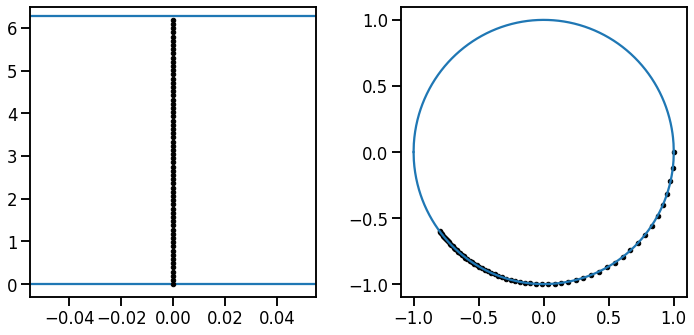

In [145]:
reload(nv)

matsubara = 2*np.pi*freq/nt * 1j
# ng = np.fft.fft(corr )
# ng = pole(m0, matsubara) - pole(-m0,  matsubara)

with sns.plotting_context('talk'):

    x = matsubara.real
    y = matsubara.imag
    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr
    plt.errorbar(ax1, x, y, fmt='.', color='k')
    ax1.axhline(y=0)
    ax1.axhline(y=2*np.pi)

    for val in ng:
        tmp = nv.moebius(val)
        x = tmp.real
        y = tmp.imag
        plt.errorbar(ax2, x, y, fmt='.', color='k')

    x = np.linspace(-1,1,num=1000)
    y = np.sqrt(1-x**2)
    plt.errorbar(ax2, x, y, fmt='-')
    y = -np.sqrt(1-x**2)
    plt.errorbar(ax2, x, y, fmt='-', color=ax2.lines[-1].get_color())

    ax2.set_xticks([-1, -0.5, 0, 0.5, 1.0])
    ax2.set_yticks([-1, -0.5, 0, 0.5, 1.0])

    fig.tight_layout()
    


    

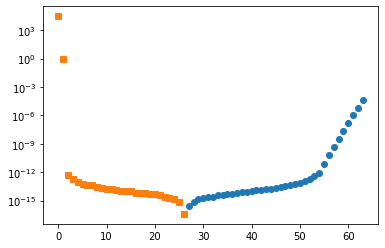

In [147]:
matsubara = (2*freq+1)*np.pi/nt * 1j
# ng = pole(m0, matsubara) - pole(-m0, matsubara)
# ng = np.fft.fft(corr)
ng = -analytic_ft(m0, matsubara, nt)

xmin = 0
xmax = 64
step = 1
pick_mat = nv.pick_matrix((matsubara[xmin:xmax:step]+1j*1e-6), ng[xmin:xmax:step])
w = np.linalg.eigvalsh(pick_mat)
fig, ax = plt.subplots(1)
neg = w < 0
pos = w > 0
if np.any(pos):
    plt.errorbar(ax, np.arange(len(w))[pos], w[pos], fmt='o')
if np.any(neg):
    plt.errorbar(ax, np.arange(len(w))[neg], -w[neg], fmt='s')
    
ax.set_yscale("log")

In [168]:
reload(nv)
eps = 1e-6

matsubara = (2*freq)*np.pi/nt * 1j
# ng = -analytic_ft(m0, matsubara, nt)
# ng = np.fft.fft(corr)
ng = pole(m0, matsubara) + pole(-m0, matsubara)
xmin = 1
xmax = 64

# print("Matsubara frequencies")
# print(matsubara[xmin:xmax])
# print("Nevanlinnna Green function NG")
# print(ng[xmin:xmax])
# print("Moebius transform h(NG)")
target1 = nv.moebius(ng[xmin:xmax])
target2 = ng[xmin:xmax]
# print(target)
# print()

tmp_nv = nv.Nevanlinna(matsubara[xmin:xmax], ng[xmin:xmax])    
print("Evaluating interpolant")
result1 = np.array([tmp_nv.schur(z, map_back=False) for z in matsubara[xmin:xmax]])
result2 = np.array([tmp_nv.schur(z, map_back=True) for z in matsubara[xmin:xmax]])



Initializing
Evaluating interpolant


# Check interpolation

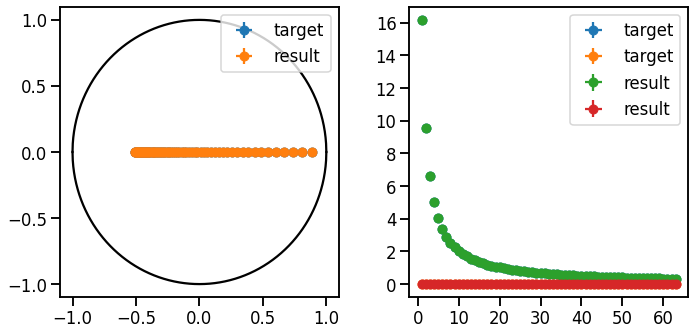

In [169]:
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
    ax1, ax2 = axarr
    
    ax = ax1
    x = np.linspace(-1,1,num=1000)
    y = np.sqrt(1-x**2)
    plt.errorbar(ax, x, y, fmt='-', color='k')
    y = -np.sqrt(1-x**2)
    plt.errorbar(ax, x, y, fmt='-', color='k')

    ax.set_xticks([-1, -0.5, 0, 0.5, 1.0])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1.0])
    zz = {
        'target': target1,
        'result': result1,
    }

    for (label, z) in zz.items():
        y = z.imag
        x = z.real
        plt.errorbar(ax, x, y, fmt='o', label=label)
    ax.legend(loc=1)
        
    ax=ax2
    yy = {
        'target': target2,
        'result': result2,
    }
    for label, y in yy.items():
        x = freq[xmin:xmax]
        plt.errorbar(ax, x, y.imag, fmt='o', label=label)
        plt.errorbar(ax, x, y.real, fmt='o', label=label)        
#     ax.set_yscale("log")
    ax.legend(loc=1)
    fig.tight_layout()
        


# Check behavior in complex plane

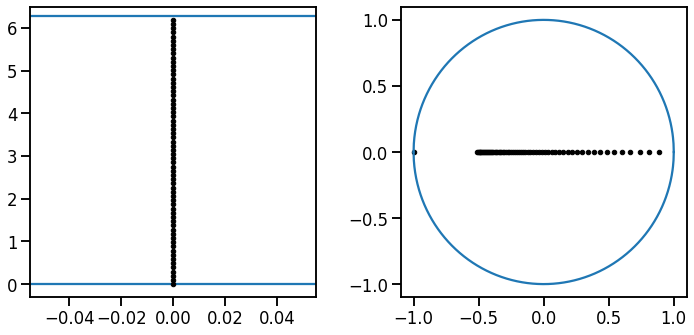

In [170]:
reload(nv)
matsubara = 2*np.pi*(freq)/nt * 1j
# ng = np.fft.fft(corr)
ng = pole(m0, matsubara) + pole(-m0, matsubara)
# ng = -analytic_ft(m0, matsubara, nt)

with sns.plotting_context('talk'):

    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr

    x = matsubara.real
    y = matsubara.imag
    plt.errorbar(ax1, x, y, fmt='.', color='k')
    ax1.axhline(y=0)
    ax1.axhline(y=2*np.pi)

    for val in ng:
        tmp = nv.moebius(val)
        x = tmp.real
        y = tmp.imag
        plt.errorbar(ax2, x, y, fmt='.', color='k')

    x = np.linspace(-1,1,num=1000)
    y = np.sqrt(1-x**2)
    plt.errorbar(ax2, x, y, fmt='-')
    y = -np.sqrt(1-x**2)
    plt.errorbar(ax2, x, y, fmt='-', color=ax2.lines[-1].get_color())

    ax2.set_xticks([-1, -0.5, 0, 0.5, 1.0])
    ax2.set_yticks([-1, -0.5, 0, 0.5, 1.0])

    fig.tight_layout()
    


    

# Compute spectral density

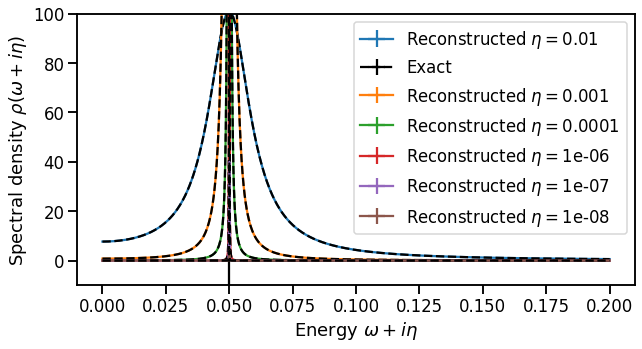

In [174]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.axvline(x=m0, color='k')
    for eta in [1e-2, 1e-3, 1e-4, 1e-6, 1e-7, 1e-8]:
        omega, rho = tmp_nv(start=0, stop=0.2, num=1000, eta=eta)
        plt.errorbar(ax, omega.real, rho.imag, label=r"Reconstructed $\eta=$"+str(eta))
#         y = analytic_ft(m0, omega, nt).imag
        y = pole(m0, omega).imag + pole(-m0, omega).imag
        x = omega.real
        if eta == 1e-2:
            label = 'Exact'
        else:
            label = None
        plt.errorbar(ax, x, y, fmt='--', color='k', label=label)
    ax.set_ylim(-10, 100)
#     ax.set_xlim(xmax=0.5)
#     ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel(r"Energy $\omega + i \eta$")
    ax.set_ylabel(r"Spectral density $\rho(\omega + i \eta)$")

# Messing around

(-1.1, 1.1)

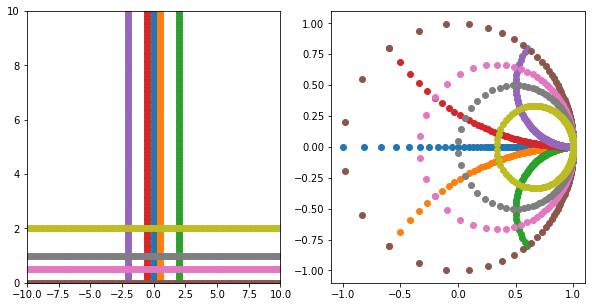

In [173]:
fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
ax1, ax2 = axarr

zmax = 100
num = 1000

x = np.linspace(0, zmax)
zz = [
    # Vertical lines
    np.linspace(0, zmax, num)*1j,
    np.linspace(0, zmax, num)*1j + 0.5,
    np.linspace(0, zmax, num)*1j + 2,    
    np.linspace(0, zmax, num)*1j - 0.5,
    np.linspace(0, zmax, num)*1j - 2,    
    # Horizontal lines
    np.linspace(-zmax, zmax, num),    
    np.linspace(-zmax, zmax, num) + 0.5j,
    np.linspace(-zmax, zmax, num) + 1j,
    np.linspace(-zmax, zmax, num) + 2j,
]




for z in zz:

    h = nv.moebius(z)
    plt.errorbar(ax1, z.real, z.imag, fmt='o')
    plt.errorbar(ax2, h.real, h.imag, fmt='o')

    
ax1.set_ylim(0, 10)    
ax1.set_xlim(-10, 10)
    
bound = 1.1
ax2.set_xlim(-bound, +bound)
ax2.set_ylim(-bound, +bound)




In [3]:
reload(nv)

lam = nv.h(ng)
pick = nv.construct_pick(freq, lam)

y = [gmp.mpc(0, float(yi)) for yi in freq]

ng_real = nv.nevanlinna(freq, -ng, omega_min=0, omega_max=2, n_real=601)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
phi[k] is: [mpc('0.648054273663885415693339530370862974342+0.7615941559557648744040517085453386808031j',(128,128))
 mpc('-0.6480542736638854156933395303708629742392-0.7615941559557648744040517085453386808912j',(128,128))
 mpc('0.6504675135726395380097343344357313409153+0.7595340767777493197012718561622283294148j',(128,128))
 mpc('-0.6504675135726395380097343344357315388744-0.7595340767777493197012718561622281598615j',(128,128))
 mpc('0.6502674910014975094528573437998608777976+0.7597053311295224520110054594464702475505j',(128,128))
 mpc('-0.6502674910014975094528573437998601768562-0.7597053311295224520110054594464708475287j',(128,128))
 mpc('0.6502407827399662045608477753431621240533+0.7597281911721560358738728621008952854159j',(128,128))
 mpc('-0.6502407827399662045608477753431606217275-0.7597

ValueError: ('Invalid analytic continuation.', 0, mpc('nan+nanj',(128,128)), (-2.163953413738653-0j))

In [7]:
reload(nv)

lam = nv.h(ng)

def construct_phi(y, lam):
    """
    Construct phi[k] = theta_k(Y_k)
    """
    n = len(y)
    
    
    abcd_bar_lst = []
    for k in range(n-1):
        id = np.array([
            [gmp.mpc(1, 0), gmp.mpc(0, 0)],
            [gmp.mpc(0, 0), gmp.mpc(1, 0)]
        ])
        abcd_bar_lst.append(id)
    phi = np.full((len(y)), gmp.mpc(0, 0), dtype = object)
    phi[0] = lam[0]
#     print("y=",y)
    for k in range(n-1):  
        print("#"*40)
        print("Constructing phi[k+1], k+1 =", k+1)
        print("#"*40)
        for j in range(k, n-1):
            print("j=",j)
            xi_k = (y[j + 1] - y[k]) / (y[j + 1] - nv.conj(y[k]))
            factor = np.array([
                [xi_k, phi[k]],
                [nv.conj(phi[k]) * xi_k, gmp.mpc(1, 0)]
            ])
            abcd_bar_lst[j] = abcd_bar_lst[j] @ factor
        num = lam[k + 1] * abcd_bar_lst[k][1, 1] - abcd_bar_lst[k][0, 1]
        denom = abcd_bar_lst[k][0, 0] - lam[k + 1] * abcd_bar_lst[k][1, 0]
        phi[k + 1] = num / denom
        break
    return phi

y = [gmp.mpc(0, float(yi)) for yi in freq]

foo = construct_phi(y=y, lam=lam)



########################################
Constructing phi[k+1], k+1 = 1
########################################
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
j= 15
j= 16
j= 17
j= 18
j= 19
j= 20
j= 21
j= 22
j= 23
j= 24
j= 25
j= 26
j= 27
j= 28
j= 29
j= 30
j= 31
j= 32
j= 33
j= 34
j= 35
j= 36
j= 37
j= 38
j= 39
j= 40
j= 41
j= 42
j= 43
j= 44
j= 45
j= 46
j= 47
j= 48
j= 49
j= 50
j= 51
j= 52
j= 53
j= 54
j= 55
j= 56
j= 57
j= 58
j= 59
j= 60
j= 61
j= 62


In [51]:
y = freq
c = ng

omega_min = 0
omega_max = 2
n_real = 601
eta = 1e-3

def theta_mp1(z):
        """ Interpolant function theta_{M+1}. This can be adjusted for numerical convenience. """
        return 0
    
if len(y) != len(c):
    raise ValueError('The frequencies and the Green function have different sizes', len(y), len(c))

# Confirm that we're using a Nevanlinna function
for z in c:
    if not (z.imag >= 0.0):
        raise ValueError('Negative of input function is not Nevanlinna.')

lam = nv.h(c)

# Construct Pick matrix to check that the Nevanlinna interpolant exists
# pick = construct_pick(y, lam)
# TODO implement check for positive semidefinite-ness    
# print("Completed Pick matrix.")

# Construct phi[k] = theta_k(Y_k)
phi = nv.construct_phi(y, lam)


zmesh = np.linspace(omega_min, omega_max, num=n_real)
zspace = np.array([gmp.mpc(z, eta) for z in zmesh])
ng_real = nv.analytic_continuation(y, phi, zspace, theta_mp1)

# Confirm this is a valid analytic continuation-- it extends the input points
# test_cont = analytic_continuation(y, phi, y, theta_mp1)
# for k in range(len(c)):
#     if not abs(test_cont[k] - c[k]) < gmp.mpfr(1e-15):
#         raise ValueError("Invalid analytic continuation.", k, test_cont[k], c[k])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


<ErrorbarContainer object of 3 artists>

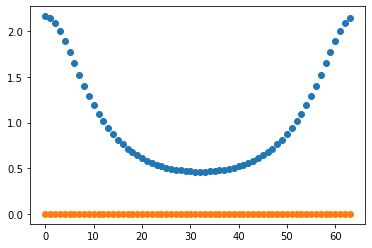

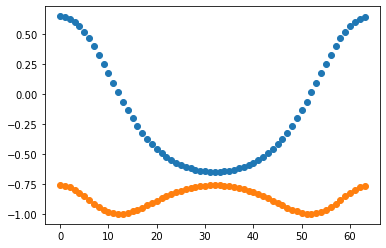

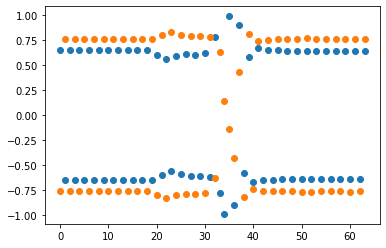

In [70]:
fig, ax = plt.subplots(1)
y = [yi.real for yi in ng]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')
y = [yi.imag for yi in ng]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')

fig, ax = plt.subplots(1)
y = [yi.real for yi in lam]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')
y = [yi.imag for yi in lam]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')

fig, ax = plt.subplots(1)
y = [yi.real for yi in phi]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')
y = [yi.imag for yi in phi]
ax.errorbar(x=np.arange(len(y)), y=y, fmt='o')





<ErrorbarContainer object of 3 artists>

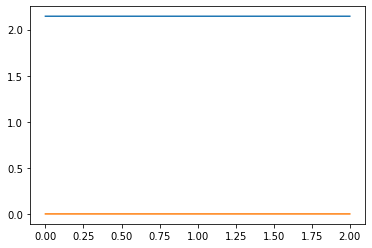

In [5]:
x = np.linspace(0, 2, num=6001)

plt.errorbar(x=x, y=[val.real for val in ng_real])
plt.errorbar(x=x, y=[val.imag for val in ng_real])

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


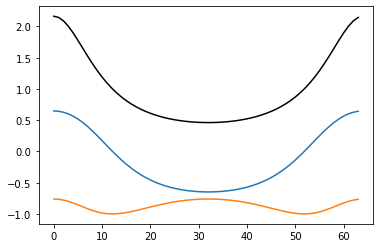

In [6]:
plt.plot(matsubara, label='matsubara', color='k')
plt.plot([y.real for y in nv.h(matsubara)], label='Mobius real')
plt.plot([y.imag for y in nv.h(matsubara)], label='Mobius imag')

# Thiele Interpolaton

Starting


<ErrorbarContainer object of 3 artists>

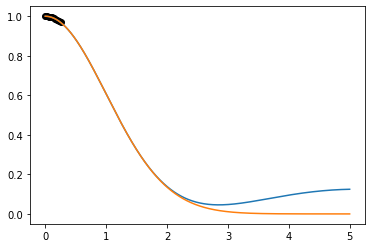

In [10]:
class ThieleInterpolator:
    """
    Compute the Thiel interpolant.
    
    The following reference was useful during the writing of this implementation:
        https://rosettacode.org/wiki/Thiele%27s_interpolation_formula    
    """
    def __init__(self, xdata, ydata):
        print("Starting")
        self.xdata = np.array(xdata)
        self.ydata = np.array(ydata)
        self.rho = self.initialize()
        
    def initialize(self):
        """
        Computes the required reciprocal differences.
        https://en.wikipedia.org/wiki/Reciprocal_difference
        """
        
        x = self.xdata
        y = self.ydata
        if len(x) != len(y):
            raise ValueError("Incomensurate sizes")
          
        n = len(y)    
        rho = [[0]*(n-i) for i in range(n)]

        # Base Case 0: Initialize first row to rho_0 = y
        for i, yi in enumerate(y):
            rho[0][i] = yi
                
        # Base Case 1: Initialize second column to rho_1(x[i], x[i+1])
        for i in range(n-1):
            rho[1][i] = (x[i] - x[i+1]) / (rho[0][i] - rho[0][i+1])
            
        # Recursion: Compute rho_n starting from rho_{n-1} and rho_{n-2}
        for i in range(2, n):
            for j in range(n-i):
                rho[i][j] = (x[j]-x[j+i]) / (rho[i-1][j]-rho[i-1][j+1]) + rho[i-2][j+1]
        
        return [rho[i][0] for i in range(n)]
      
    
    def __call__(self, x):
        """
        Computes the Thiele interpolant, which is based on a certain continued
        fraction representation.
        See:
            https://en.wikipedia.org/wiki/Thiele%27s_interpolation_formula
            https://mathworld.wolfram.com/ThielesInterpolationFormula.html
            https://en.wikipedia.org/wiki/Reciprocal_difference
            https://rosettacode.org/wiki/Thiele%27s_interpolation_formula
        """
        rho = self.rho
        xdata = self.xdata
        ydata = self.ydata
        # Start from maximum depth n-1 and build up
        # the continued fraction representation
        a = 0
        for n in range(len(rho)-1, 1, -1):
            a = (x - xdata[n-1]) / (rho[n] - rho[n-2] + a)
        return ydata[0] + (x - xdata[0])/(rho[1] + a)

x = np.linspace(0,0.125, num=10)
y = np.exp(-0.5*x**2)
f = ThieleInterpolator(x, y)

fig, ax = plt.subplots(1)
ax.errorbar(x, y, fmt='o', color='k')
x = np.linspace(0,5, num=5000)
ax.errorbar(x, f(x))

y = np.exp(-0.5*x**2)
ax.errorbar(x, y)

# # task 1: build 32 row trig table
# x = np.linspace(0, 0.5*np.pi, num=5)
# sin = np.sin(x)
# cos = np.cos(x)
# tan = np.tan(x)

# # task 2: define inverses
# isin = thieleInterpolator(sin, x)
# icos = thieleInterpolator(cos, x)
# itan = thieleInterpolator(tan, x)
    
# # task 3: demonstrate identities
# print('{:16.14f}'.format(6*isin(0.5)))
# print('{:16.14f}'.format(3*icos(0.5)))
# print('{:16.14f}'.format(4*itan(1)))



# Finite-volume counting

In [31]:
import pandas as pd
import itertools
import numpy as np
from lqcd_analysis import visualize as plt

In [17]:
ns = 32
sites = [xyzt for xyzt in itertools.product(range(ns), repeat=4)]
sites = pd.DataFrame(sites)
sites['n2'] = sites[[0,1,2,3]].apply(lambda args: np.sum(np.array(args)**2), axis=1)

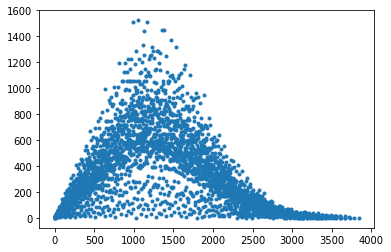

In [34]:
x = sites.groupby('n2').size().index
y = sites.groupby('n2').size().values

fig, ax = plt.subplots(1)
plt.errorbar(ax, x, y, fmt='.')


In [30]:
sites.groupby('n2').size()

n2
0       1
1       4
2       6
3       4
4       5
       ..
3667    4
3722    6
3724    4
3783    4
3844    1
Length: 3168, dtype: int64

In [47]:
print(np.sqrt(0.4**2 + 0.9**2) / 39.1)
print(1/40)
print(np.sqrt(0.9**2 + 0.4**2) / 39.1)
print(2.2/41.3)
print(np.sqrt(0.49**2 + 0.53**2 + 0.19**2) / 39.04)
print(np.sqrt(0.66*2 + 0.34**2)/38.40)
print(0.16/3.72)
print(0.32/3.61)
print(0.41/3.93)
print(0.68808 * 0.197 / 0.055)
print(1.25**4)

0.02518889463374963
0.025
0.02518889463374963
0.05326876513317192
0.01911863007882899
0.0312022204182295
0.04301075268817204
0.0886426592797784
0.10432569974554706
2.464577454545455
2.44140625


In [59]:
print(0.12 * 12, 0.12*17)
print(0.09 * 16, 0.09*25)
print(0.06 * 23, 0.06*37)
print(0.042*34, 0.042*52)

1.44 2.04
1.44 2.25
1.38 2.2199999999999998
1.4280000000000002 2.184
